# Pytorch

## Preprocessing the data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
df = pd.read_csv('cleaned_data/aalborg_data.csv')
df.head()

,angle,rpm,speed_x,speed_y,track_position,acceleration,brake,steer
0,0.227636,942,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
1,0.227636,1100,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
2,0.227636,1263,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
3,0.227636,1432,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
4,0.227636,1605,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716


In [5]:
# Select relevant columns for features and target
features = df[['angle', 'rpm', 'speed_x', 'speed_y', 'track_position']]
targets = df[['acceleration', 'brake', 'steer']]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)


## Create the model

In [6]:
import torch.nn as nn

class CarControlModel(nn.Module):
    def __init__(self):
        super(CarControlModel, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # 5 input features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 output actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CarControlModel().to(device)


In [7]:
import torch.optim as optim
from tqdm.auto import tqdm

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
batch_size = 10

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    for i, (inputs, targets) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        


        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.1044
Epoch [2/100], Loss: 0.0221
Epoch [3/100], Loss: 0.0082
Epoch [4/100], Loss: 0.0021
Epoch [5/100], Loss: 0.0013
Epoch [6/100], Loss: 0.0314
Epoch [7/100], Loss: 0.0096
Epoch [8/100], Loss: 0.0051
Epoch [9/100], Loss: 0.0137
Epoch [10/100], Loss: 0.0043
Epoch [11/100], Loss: 0.0314
Epoch [12/100], Loss: 0.0024
Epoch [13/100], Loss: 0.0088
Epoch [14/100], Loss: 0.1512
Epoch [15/100], Loss: 0.0086
Epoch [16/100], Loss: 0.0015
Epoch [17/100], Loss: 0.0002
Epoch [18/100], Loss: 0.0016
Epoch [19/100], Loss: 0.0080
Epoch [20/100], Loss: 0.0507
Epoch [21/100], Loss: 0.0294
Epoch [22/100], Loss: 0.0035
Epoch [23/100], Loss: 0.0082
Epoch [24/100], Loss: 0.0006
Epoch [25/100], Loss: 0.0013
Epoch [26/100], Loss: 0.0034
Epoch [27/100], Loss: 0.0023
Epoch [28/100], Loss: 0.0123
Epoch [29/100], Loss: 0.0035
Epoch [30/100], Loss: 0.0034
Epoch [31/100], Loss: 0.0029
Epoch [32/100], Loss: 0.0015
Epoch [33/100], Loss: 0.0016
Epoch [34/100], Loss: 0.0008
Epoch [35/100], Loss: 0

Cost graph

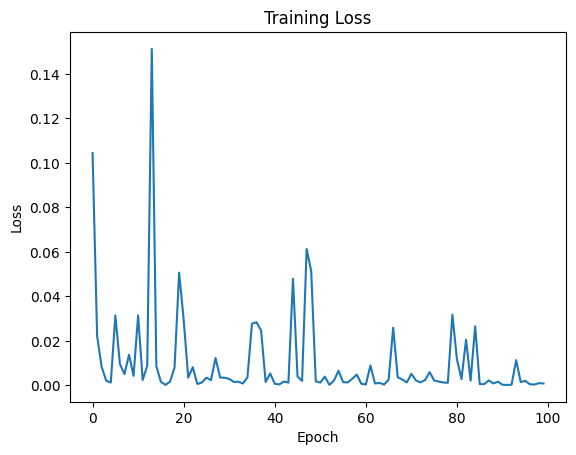

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Calculate the accuracy

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        predictions = model(X_test).cpu().numpy()  # Make predictions and move to CPU
        targets = y_test.cpu().numpy()  # Move targets to CPU
    
    # Calculate evaluation metrics
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-squared (R²): {r2:.4f}')
    
    return mse, mae, r2

mse, mae, r2 = evaluate_model(model, X_test, y_test)


## Save the model

In [ ]:
# Save the model
torch.save(model.state_dict(), 'models/car_control_model.pth')

In [ ]:
# load the model
model_loaded = CarControlModel().to(device)
model_loaded.load_state_dict(torch.load('models/car_control_model.pth'))


In [ ]:
# Save scaler
import pickle

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    

## Make predictions